In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import random

import warnings
warnings.filterwarnings("ignore")

from PIL import Image

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


Uncomment the below code if you need to unzip the data

In [3]:
# from zipfile import ZipFile

# with ZipFile('/content/drive/MyDrive/Semester 5 (3-1)/archive.zip','r') as obj:
#   obj.extractall('/content/archive')

In [4]:
random.seed(42)

In [5]:
def display_images_matrix(folder_path, num_images=20, images_per_column=4):

    # Listing all files in the folder
    files = os.listdir(folder_path)

    # Filtering only image files
    image_files = [file for file in files if file.lower().endswith(('.png', '.jpg'))]

    selected_files = random.sample(image_files,num_images)
    num_rows = (num_images + images_per_column - 1) // images_per_column

    # Setting up the subplots
    fig, axes = plt.subplots(num_rows, images_per_column, figsize=(12, 3*num_rows))

    # Adding each image file to the subplot
    for idx, image_file in enumerate(selected_files):
        image_path = os.path.join(folder_path, image_file)

        try:
            # Opening the image
            img = Image.open(image_path)

            # Adding image to the subplot
            axes[idx // images_per_column, idx % images_per_column].imshow(img)
            axes[idx // images_per_column, idx % images_per_column].axis('off')

            # Closing the image
            img.close()
        except Exception as e:
            print(f"Error processing {image_file}: {str(e)}")

    # Adjusting the layout and displaying the subplots
    plt.tight_layout()
    plt.show()

The real images from Training Dataset are:


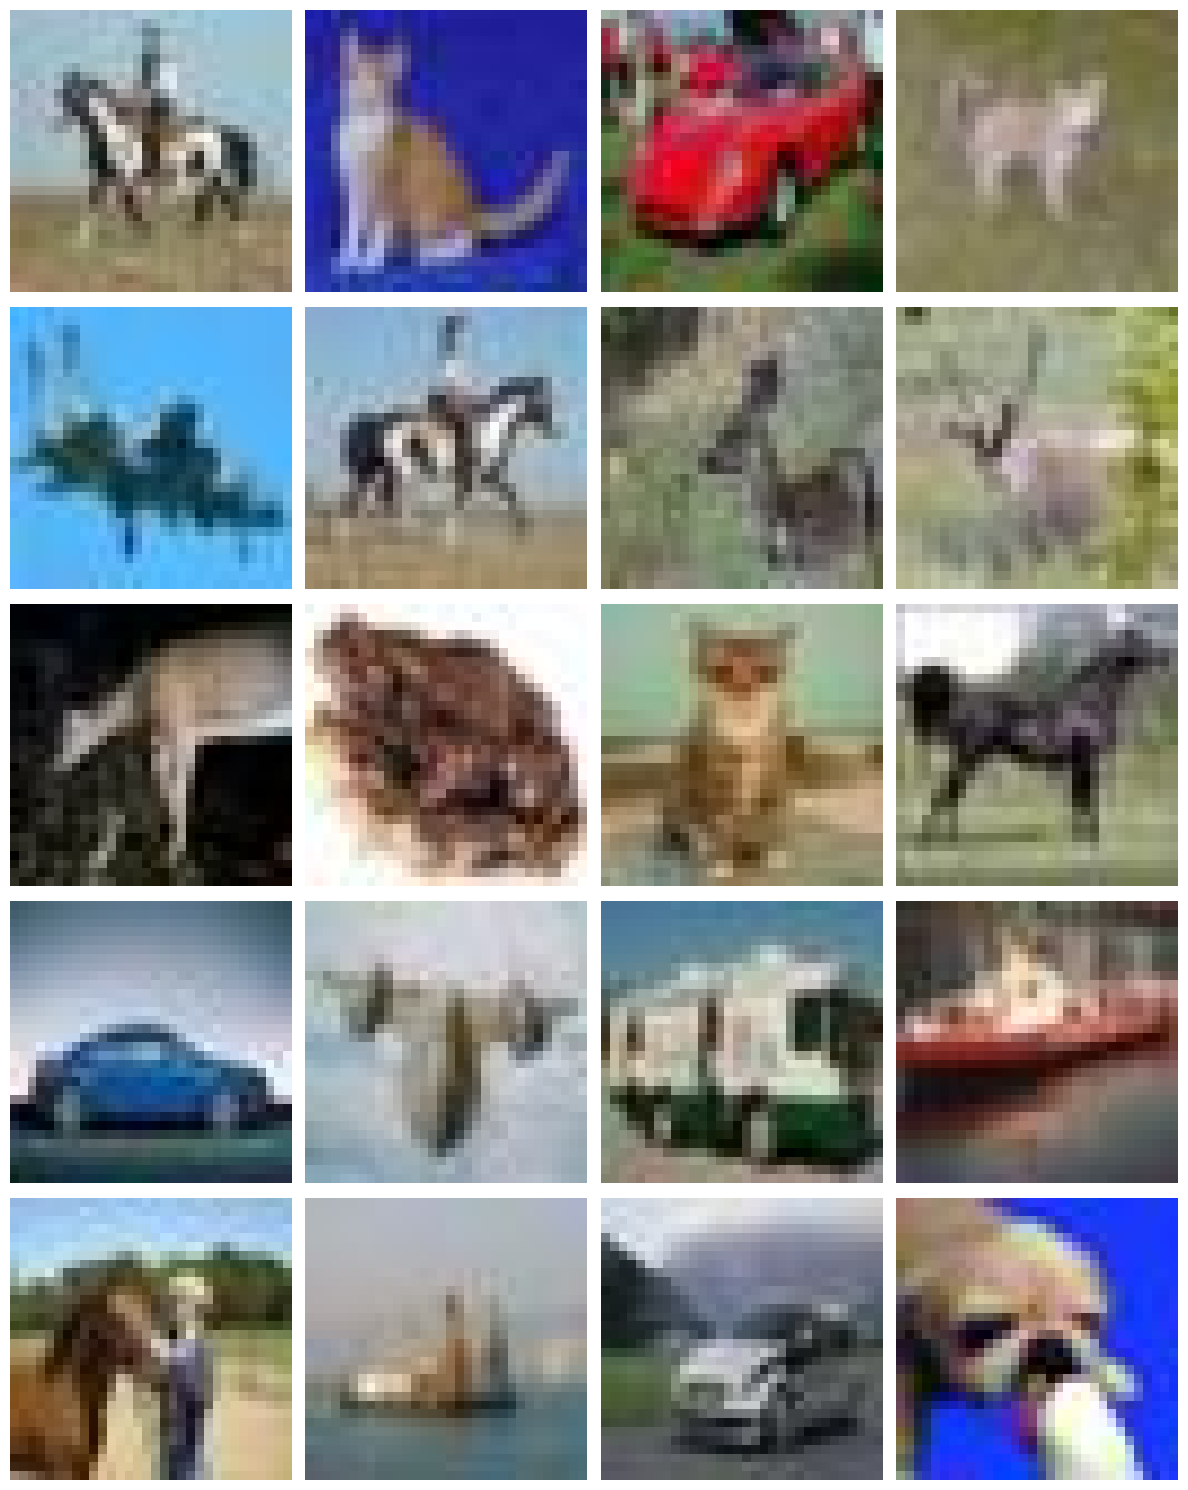

In [6]:
folder_path = '/content/archive/archive/train/REAL'
num_images_to_display = 20
images_per_column = 4
print("The real images from Training Dataset are:")
display_images_matrix(folder_path, num_images=num_images_to_display, images_per_column=images_per_column)


The fake images from Training Dataset are:


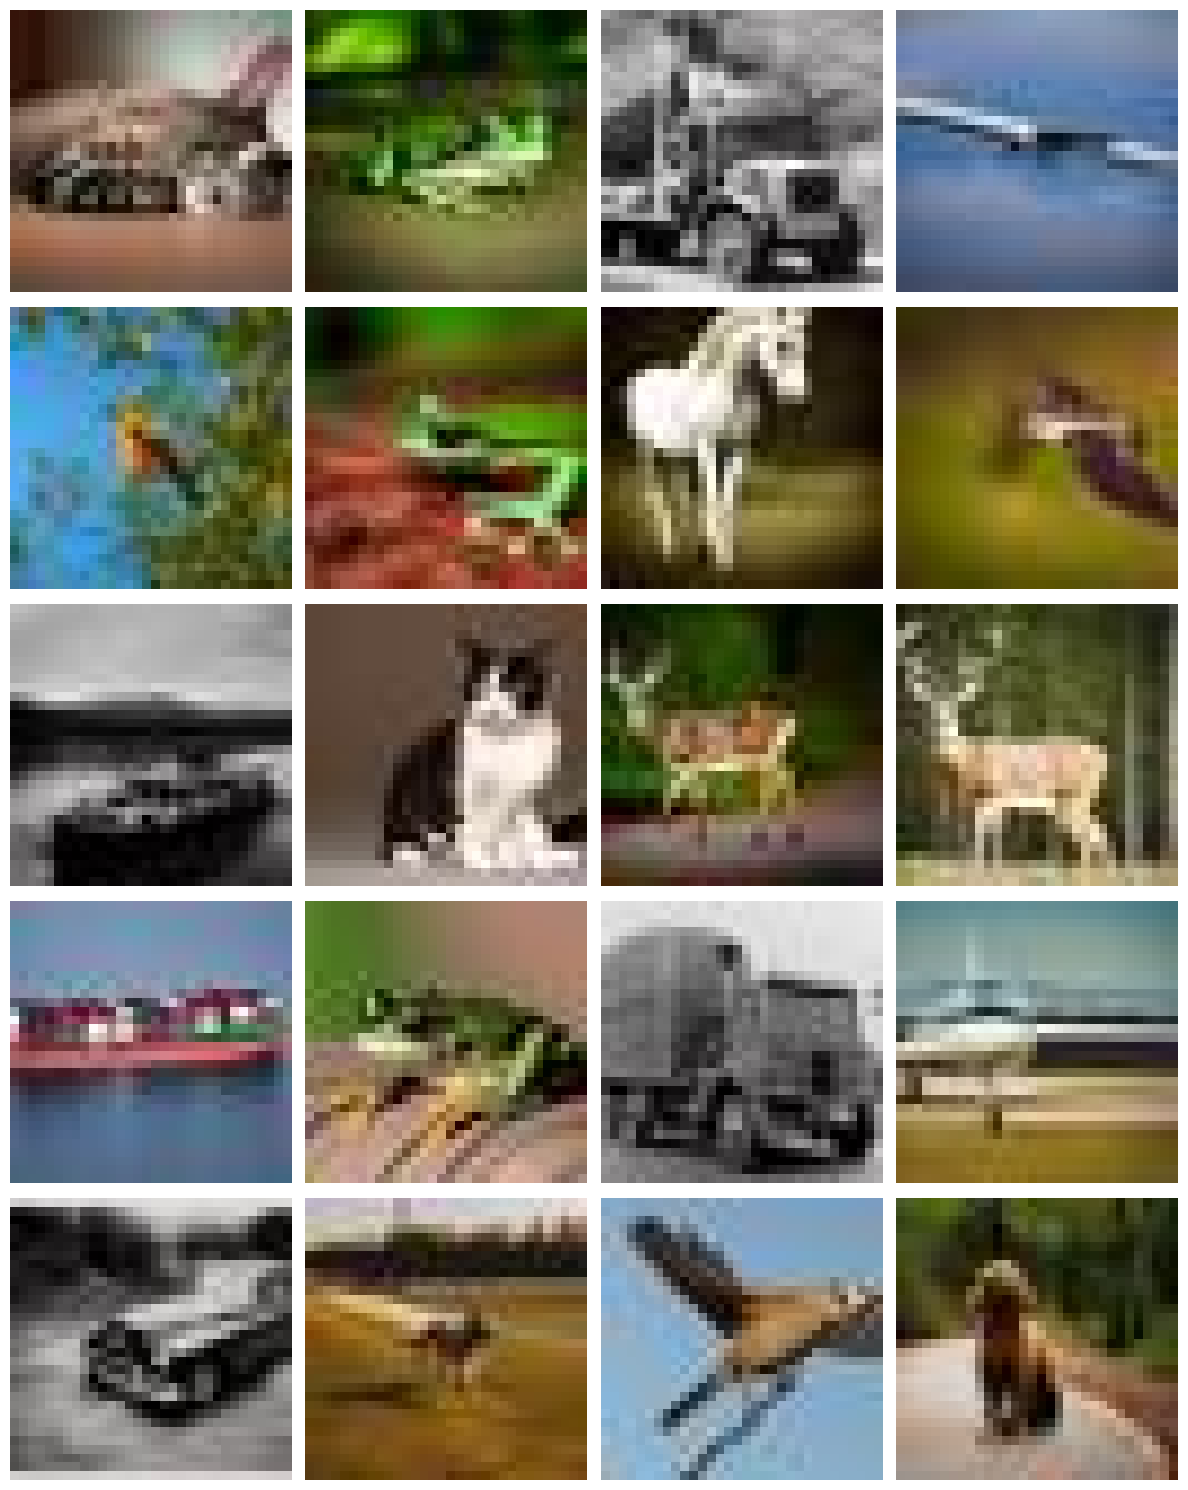

In [7]:
folder_path = '/content/archive/archive/train/FAKE'
num_images_to_display = 20
images_per_column = 4
print("The fake images from Training Dataset are:")
display_images_matrix(folder_path, num_images=num_images_to_display, images_per_column=images_per_column)


In [8]:
def load_images(folder_path, label, num_images):

    # Listing all files in the folder
    files = os.listdir(folder_path)

    # Filtering out only image files
    image_files = [file for file in files if file.lower().endswith(('.png', '.jpg'))]

    selected_files = random.sample(image_files,num_images)

    # lists to store images and labels
    images = []
    labels = []

    # Adding image files to the lists
    for image_file in selected_files:
        image_path = os.path.join(folder_path, image_file)

        try:
            # Opening and resizing the image to a common size
            img = Image.open(image_path).resize((64, 64))

            # Converting the image to a numpy array and flattening it
            img_array = np.array(img).flatten()

            # Append the flattened image to the list of images
            images.append(img_array)

            # Assign the label based on the provided label argument
            labels.append(label)

            # Closing the image
            img.close()
        except Exception as e:
            print(f"Error processing {image_file}: {str(e)}")

    return np.array(images), np.array(labels)

Training the whole data leads to system crash.

So taking 20k images from training data and 5k images from test data.

In [9]:
real_folder_path = '/content/archive/archive/train/REAL'
fake_folder_path = '/content/archive/archive/train/FAKE'
num_images_per_class = 20000
# total length of training dataset is 50k

# Loading real images and labels (label 1 for real images)
real_images, real_labels = load_images(real_folder_path, label=1,num_images=num_images_per_class)

# Loading fake images and labels (label 0 for fake images)
fake_images, fake_labels = load_images(fake_folder_path, label=0,num_images=num_images_per_class)


In [10]:
# Combining real and fake images and labels separately
all_images = np.concatenate((real_images, fake_images), axis=0)
all_labels = np.concatenate((real_labels, fake_labels), axis=0)


In [11]:
print(all_images)

[[176 171 142 ... 115 110  88]
 [130 134 143 ...  71  74  83]
 [ 90  76 128 ...  84  47  99]
 ...
 [197 200 170 ... 128 153 136]
 [ 99  74  21 ...  70  54   3]
 [  7  11   0 ...  57  32   2]]


In [12]:
print(all_labels)

[1 1 1 ... 0 0 0]


Scaling is required for images array

Also, Concatenation is done in one way.

That means all real images are first then fake one.
We should shuffle this to maintain the randomness

In [13]:
# Shuffling the indices
indices = np.arange(all_images.shape[0])
np.random.shuffle(indices)

# Using the shuffled indices to shuffle the images and labels
shuffled_images = all_images[indices]
shuffled_labels = all_labels[indices]

In [14]:
print(shuffled_images)

[[181 182 196 ... 128 131 108]
 [154 169 190 ... 231 208 189]
 [ 84  77  79 ... 114 110 109]
 ...
 [ 71  58  23 ...  60  63  44]
 [210 210 210 ...  97  97  97]
 [120 149 179 ... 142 157 180]]


In [15]:
print(shuffled_labels)

[1 1 1 ... 0 0 0]


In [16]:
scaler = StandardScaler()
scaled_images = scaler.fit_transform(shuffled_images)

print(scaled_images)

[[ 0.98054144  0.91034031  1.02898123 ...  0.24069231  0.33848814
   0.15364412]
 [ 0.59515716  0.72545351  0.95505271 ...  1.91015472  1.61870988
   1.37622829]
 [-0.40398728 -0.58297618 -0.41262497 ...  0.01377509 -0.01066325
   0.16873775]
 ...
 [-0.58954268 -0.85319535 -1.10262451 ... -0.86147705 -0.7920973
  -0.81234832]
 [ 1.39447271  1.30855804  1.20148112 ... -0.26176725 -0.22680458
  -0.01238583]
 [ 0.10985843  0.44101227  0.81951708 ...  0.46760953  0.7707708
   1.2403856 ]]


In [17]:
# Splitting the training data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(scaled_images, shuffled_labels, test_size=0.2, random_state=42)


In [18]:
print(X_train)

[[ 0.75216557  0.6543432   0.47451731 ... -0.86147705 -0.84197607
  -1.3255318 ]
 [-0.21843189 -0.69675267 -0.58512485 ...  1.22940306  0.80402332
   0.38004859]
 [-1.17475585 -0.85319535 -1.09030309 ...  0.66211001  0.5047507
  -0.02747947]
 ...
 [-1.28894379 -1.37941164 -1.15191019 ... -1.50981196 -1.52365258
  -1.21987638]
 [-0.47535474 -0.39808938 -0.32637502 ...  0.4838179   0.52137696
   0.87813844]
 [-1.31749077 -1.13763659 -1.38601718 ... -0.56972633 -0.11042079
  -0.96328464]]


In [19]:
print(X_test)

[[-0.87501252 -0.52608793 -0.42494639 ... -1.75293755 -1.83955146
  -1.47646812]
 [ 0.5095162   0.42679021  0.11719611 ...  0.58106814  0.62113449
   0.71210849]
 [ 1.32310525  1.06678299  1.26308822 ...  0.1272337   0.07246803
   0.25929954]
 ...
 [-1.13193537 -1.18030277 -1.01637457 ... -0.03485003 -0.06054202
   0.15364412]
 [-0.84646553 -0.92430566 -0.8561961  ... -1.38014498 -1.45714756
  -1.43118722]
 [-0.51817522 -0.62564236 -0.46191065 ... -0.68318494 -0.67571351
  -0.45010116]]


In [20]:
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [21]:
print(y_pred)

[0 1 1 ... 0 0 0]


In [22]:
print("Classification report for Logistic Regression model:\n", classification_report(y_test, y_pred))

print("Confusion matrix for Logistic Regression model:\n", confusion_matrix(y_test, y_pred))

Classification report for Logistic Regression model:
               precision    recall  f1-score   support

           0       0.65      0.66      0.65      3939
           1       0.67      0.66      0.66      4061

    accuracy                           0.66      8000
   macro avg       0.66      0.66      0.66      8000
weighted avg       0.66      0.66      0.66      8000

Confusion matrix for Logistic Regression model:
 [[2582 1357]
 [1367 2694]]


Now training the model on entire 20k images

In [23]:
model.fit(scaled_images,shuffled_labels)

LogisticRegression()

In [24]:
realtest_folder_path = '/content/archive/archive/test/REAL'
faketest_folder_path = '/content/archive/archive/test/FAKE'
num_images_per_class = 5000
# total length of testing dataset is 10k

# Loading real images and labels (label 1 for real images)
realtest_images, realtest_labels = load_images(realtest_folder_path, label=1,num_images=num_images_per_class)

# Loading fake images and labels (label 0 for fake images)
faketest_images, faketest_labels = load_images(faketest_folder_path, label=0,num_images=num_images_per_class)


In [25]:
# Combining real and fake images and labels separately
alltest_images = np.concatenate((realtest_images, faketest_images), axis=0)
alltest_labels = np.concatenate((realtest_labels, faketest_labels), axis=0)


In [26]:
print(alltest_images)

[[124 130 146 ...  91  96 116]
 [241 234 242 ... 112 114  77]
 [  6  27  10 ...  71  80  97]
 ...
 [ 21  17  16 ...  14  13  11]
 [129 166 192 ... 182 194 192]
 [202 200 201 ...  74  72  73]]


In [27]:
print(alltest_labels)

[1 1 1 ... 0 0 0]


In [28]:
# Shuffling the indices
indices1 = np.arange(alltest_images.shape[0])
np.random.shuffle(indices1)

# Using the shuffled indices to shuffle the images and labels
shuffledtest_images = alltest_images[indices1]
shuffledtest_labels = alltest_labels[indices1]

In [29]:
print(shuffledtest_images)

[[127 134 139 ... 128 148 155]
 [ 64  57  41 ...  98  80  76]
 [125 160 209 ...   8  16   2]
 ...
 [ 90 101  33 ... 186 166 165]
 [114 149 179 ... 114 147 198]
 [110 140 116 ...  81  96  53]]


In [30]:
print(shuffledtest_labels)

[1 1 1 ... 0 0 1]


In [31]:
scaledtest_images = scaler.transform(shuffledtest_images)

print(scaledtest_images)

[[ 0.20977287  0.22768134  0.32666026 ...  0.24069231  0.62113449
   0.86304481]
 [-0.68945712 -0.86741742 -0.88083894 ... -0.24555888 -0.50945094
  -0.3293521 ]
 [ 0.18122589  0.59745495  1.1891597  ... -1.70431244 -1.57353135
  -1.44628085]
 ...
 [-0.31834633 -0.2416467  -0.97941031 ...  1.18077794  0.92040711
   1.01398113]
 [ 0.02421748  0.44101227  0.81951708 ...  0.01377509  0.60450824
   1.51207098]
 [-0.03287649  0.31301371  0.04326759 ... -0.52110121 -0.24343084
  -0.67650563]]


In [32]:
y_pred1 = model.predict(scaledtest_images)

print(y_pred1)

[1 0 0 ... 0 1 0]


In [33]:
print("Classification report for Logistic Regression model:\n", classification_report(shuffledtest_labels, y_pred1))



Classification report for Logistic Regression model:
               precision    recall  f1-score   support

           0       0.67      0.68      0.67      5000
           1       0.67      0.67      0.67      5000

    accuracy                           0.67     10000
   macro avg       0.67      0.67      0.67     10000
weighted avg       0.67      0.67      0.67     10000



In [34]:
print("Confusion matrix for Logistic Regression model:\n", confusion_matrix(shuffledtest_labels, y_pred1))

Confusion matrix for Logistic Regression model:
 [[3384 1616]
 [1660 3340]]


In [35]:
accuracy = accuracy_score(shuffledtest_labels, y_pred1)
print(f"Accuracy: {accuracy}")

Accuracy: 0.6724
